In [1]:
import findspark
findspark.init()

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *

In [4]:
sc = SparkContext()
spark = SparkSession(sc)
spark = SparkSession \
   .builder \
   .appName("RideShare") \
   .getOrCreate()

In [5]:
df = spark.read.csv('data/Transportation_Network_Providers_-_Trips.csv',header=True)

In [6]:
df = (df
      .withColumn('Trip Start Timestamp',to_timestamp(col('Trip Start Timestamp'), "MM/dd/yyyy hh:mm:ss aa"))
      .withColumn('Trip End Timestamp',to_timestamp(col('Trip End Timestamp'), "MM/dd/yyyy hh:mm:ss aa"))
      .withColumn('Trip Miles',col('Trip Miles').cast('float'))
      .withColumn('Trip Seconds',col('Trip Seconds').cast('float'))
      .withColumn('Fare',col('Fare').cast('float'))
      .withColumn('Tip',col('Tip').cast('float'))
      .withColumn('Additional Charges',col('Additional Charges').cast('float'))
      .withColumn('Trip Total',col('Trip Total').cast('float'))
      .withColumn('Trips Pooled',col('Trips Pooled').cast('float'))
     )

In [7]:
df.columns

['Trip ID',
 'Trip Start Timestamp',
 'Trip End Timestamp',
 'Trip Seconds',
 'Trip Miles',
 'Pickup Census Tract',
 'Dropoff Census Tract',
 'Pickup Community Area',
 'Dropoff Community Area',
 'Fare',
 'Tip',
 'Additional Charges',
 'Trip Total',
 'Shared Trip Authorized',
 'Trips Pooled',
 'Pickup Centroid Latitude',
 'Pickup Centroid Longitude',
 'Pickup Centroid Location',
 'Dropoff Centroid Latitude',
 'Dropoff Centroid Longitude',
 'Dropoff Centroid Location']

In [8]:
summary = df.select('Trip Miles','Trip Seconds','Fare','Tip','Additional Charges',
          'Trip Total','Trips Pooled').describe().toPandas()

In [9]:
summary = summary.set_index('summary')

In [10]:
for col in summary.columns:
    summary[col] = summary[col] = pd.to_numeric(summary[col])

In [11]:
summary.round()

,Trip Miles,Trip Seconds,Fare,Tip,Additional Charges,Trip Total,Trips Pooled
summary,,,,,,,
count,128715721.0,128506753.0,128720615.0,128720723.0,128720626.0,128720615.0,128720757.0
mean,6.0,1094.0,12.0,1.0,3.0,16.0,1.0
stddev,7.0,790.0,10.0,2.0,2.0,12.0,1.0
min,0.0,0.0,0.0,0.0,0.0,0.0,1.0
max,546.0,85080.0,1400.0,200.0,97.0,1402.0,4097.0


In [12]:
miles = df.groupby('Trip Miles').count().toPandas()

Text(0.5, 1.0, 'Trip Miles Frequency')

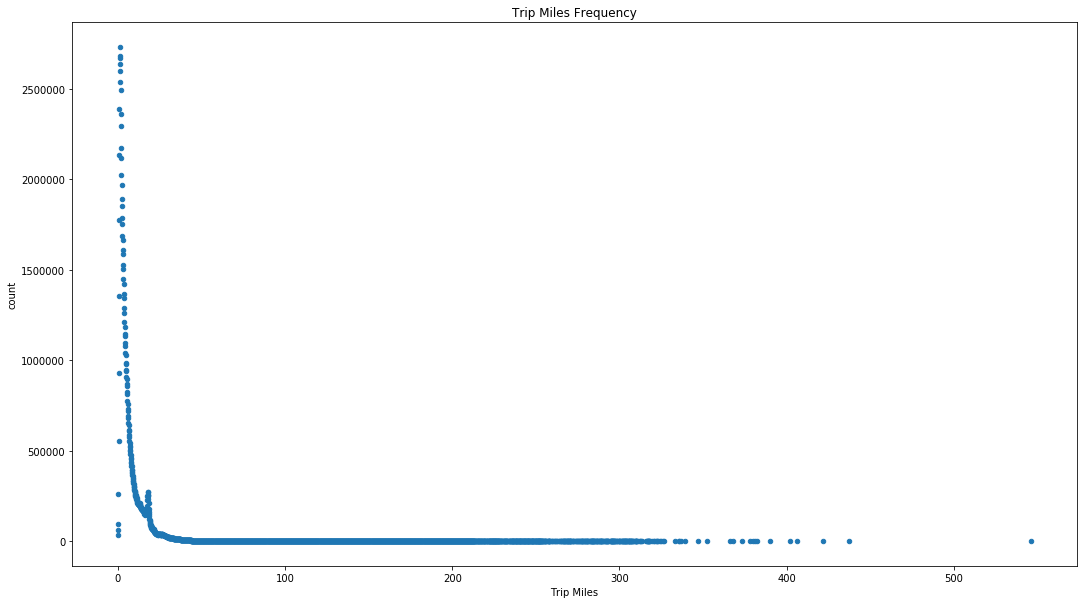

In [13]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
miles.plot(x='Trip Miles', y='count', kind='scatter', ax=ax)
plt.title('Trip Miles Frequency')

Text(0.5, 1.0, 'Trip Miles Under 20 Miles')

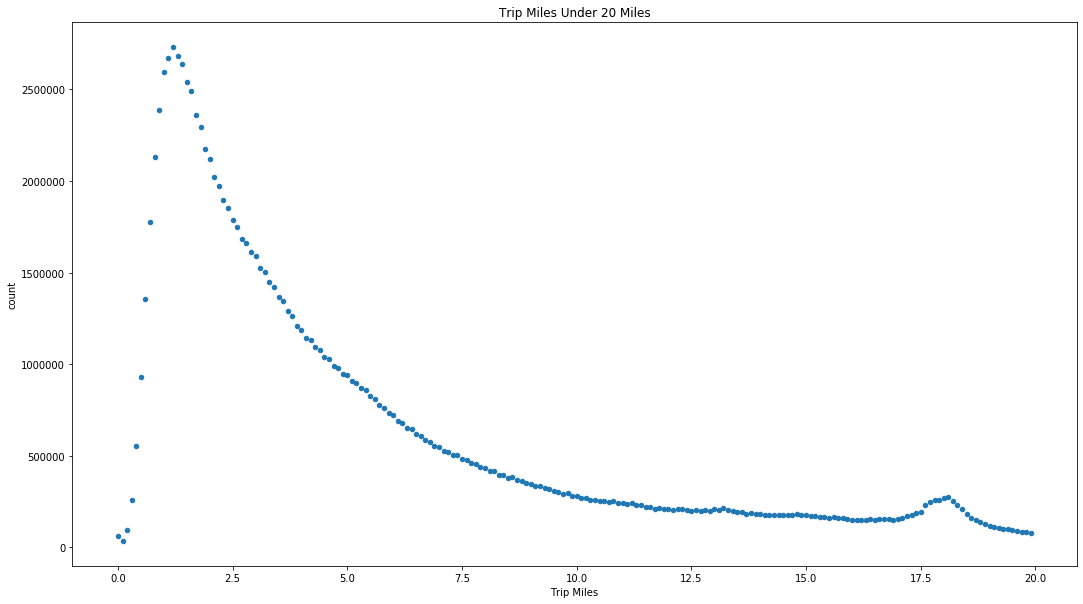

In [14]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
miles[(miles['Trip Miles'] < 20)].sort_values('Trip Miles').plot(x='Trip Miles', y='count', kind='scatter',ax=ax)
plt.title('Trip Miles Under 20 Miles')

In [15]:
pickup = df.groupby('Pickup Community Area').count().toPandas()
dropoff = df.groupby('Dropoff Community Area').count().toPandas()

In [16]:
comm_areas = pd.read_csv('data/CommAreas.csv', dtype=object)
comm_areas = comm_areas.drop(['the_geom','PERIMETER','AREA','COMAREA_',
                              'COMAREA_ID','AREA_NUM_1','SHAPE_AREA','SHAPE_LEN'], axis=1)

In [17]:
pickup = (pickup
          .merge(comm_areas, left_on=['Pickup Community Area'], right_on=['AREA_NUMBE'], how='left')
          .drop(['AREA_NUMBE','Pickup Community Area'], axis=1))

In [18]:
dropoff = (dropoff
           .merge(comm_areas, left_on=['Dropoff Community Area'], right_on=['AREA_NUMBE'], how='left')
           .drop(['AREA_NUMBE','Dropoff Community Area'], axis=1))

In [19]:
pickup = pickup.rename(columns={'count':'Pickup Cnt'})
dropoff = dropoff.rename(columns={'count':'Dropoff Cnt'})

In [20]:
locations = pickup.merge(dropoff, on='COMMUNITY', how='outer')

In [21]:
locations.sort_values('Pickup Cnt', ascending=False).head(10)

,Pickup Cnt,COMMUNITY,Dropoff Cnt
14,21207481,NEAR NORTH SIDE,20133704
53,11548407,LOOP,12736044
15,11158481,NEAR WEST SIDE,11355358
35,8527505,LAKE VIEW,8403458
22,8082891,NaN,9044518
51,7950450,WEST TOWN,7365178
0,6974012,LINCOLN PARK,6686631
16,4674632,LOGAN SQUARE,4472263
73,4640840,OHARE,5663559
10,2670004,UPTOWN,2596526


In [22]:
locations.sort_values('Dropoff Cnt', ascending=False).head(10)

,Pickup Cnt,COMMUNITY,Dropoff Cnt
14,21207481,NEAR NORTH SIDE,20133704
53,11548407,LOOP,12736044
15,11158481,NEAR WEST SIDE,11355358
22,8082891,NaN,9044518
35,8527505,LAKE VIEW,8403458
51,7950450,WEST TOWN,7365178
0,6974012,LINCOLN PARK,6686631
73,4640840,OHARE,5663559
16,4674632,LOGAN SQUARE,4472263
48,2654510,NEAR SOUTH SIDE,2684980


In [23]:
trips = df.groupby('Pickup Community Area','Dropoff Community Area').count().toPandas()

In [24]:
trips = (trips
         .merge(comm_areas, left_on=['Pickup Community Area'], right_on=['AREA_NUMBE'], how='left')
         .rename(columns={'COMMUNITY':'Pickup'})
         .drop(['Pickup Community Area','AREA_NUMBE'], axis=1)
         .merge(comm_areas, left_on=['Dropoff Community Area'], right_on=['AREA_NUMBE'], how='left')
         .rename(columns={'COMMUNITY':'Dropoff'})
         .drop(['Dropoff Community Area','AREA_NUMBE'], axis=1))

In [25]:
trips[trips['Pickup'] == trips['Dropoff']]['count'].sum()/trips['count'].sum()

0.13993937279284335

In [26]:
import numpy as np

In [27]:
np.sort()

TypeError: _sort_dispatcher() missing 1 required positional argument: 'a'

In [ ]:
trips['locations'] = [np.sort(t) for t in trips[['Pickup','Dropoff']].values.tolist()]

In [ ]:
trips['locations'] = trips['locations'].astype(str)

In [ ]:
trip_locations = trips.dropna().groupby(['locations'])['count'].sum()

In [ ]:
trip_locations.sort_values(ascending=False).head(10)

In [ ]:
trips.apply(lambda x: [x['Pickup'], x['Dropoff']])

In [ ]:
seconds = df.groupby('Trip Seconds').count().toPandas()

In [ ]:
seconds['Trip Mins'] = seconds['Trip Seconds'] / 60

In [ ]:
seconds = seconds.round()

In [ ]:
mins = seconds.groupby('Trip Mins')['count'].sum().reset_index()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
mins[mins['Trip Mins'] < 60].plot(x='Trip Mins', y='count', kind='bar', legend=False, ax=ax)
plt.title('Trips Under 1 Hour')
plt.savefig('trip_mins.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
seconds.plot(x='Trip Seconds', y='count', kind='scatter', ax=ax)
plt.title('Distribution of Length of Trips (Seconds)')

In [ ]:
fare = df.groupby('Trip Total').count().toPandas()

In [ ]:
fare['Trip Total'].min()

In [ ]:
fare_bins = [1, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 1405]

In [ ]:
fare['bins'] = pd.cut(fare['Trip Total'], fare_bins)

In [ ]:
fare_binned = fare.groupby('bins')['count'].sum().reset_index()

In [ ]:
fare_binned['bins'] = fare_binned['bins'].astype(str)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
fare_binned.plot(x='bins', y='count', ax=ax, legend=False)
plt.xlabel('Fare Bins')
plt.ylabel('Rows')
plt.title('Fare Totals')

In [ ]:
speed = (df
         .withColumn('Trip Mins', round(col('Trip Seconds')/60))
         .groupby(['Trip Mins','Trip Miles'])
         .count()
         .toPandas())

In [ ]:
speed['Trip Hours'] = speed['Trip Mins'] / 60

In [ ]:
speed['Trip Speed'] = speed['Trip Miles'] / speed['Trip Hours']

In [ ]:
speed = speed.replace(np.inf, np.nan).dropna()

In [ ]:
speed.sort_values('Trip Speed',ascending=False)

In [ ]:
speed = speed[speed['Trip Speed'] < 80]

In [ ]:
speed_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]

In [ ]:
speed['bins'] = pd.cut(speed['Trip Speed'], speed_bins)

In [ ]:
speed_bins = speed.groupby('bins')['count'].sum().reset_index()

In [ ]:
speed_bins['bins'] = speed_bins['bins'].astype(str)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
speed_bins.plot(x='bins', y='count', legend=False, ax=ax)
plt.title('Average Speed of Trips')
plt.xlabel('Speed')
plt.ylabel('Number of Trips')
plt.savefig('speed.png', bbox_inches='ti')

In [95]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [106]:
vecAssembler = VectorAssembler(inputCols=['Trip Total','Trip Miles','Trip Seconds'], outputCol="features")
new_df = vecAssembler.transform(df)

In [107]:
new_df = new_df.select('Trip Total','Trip Miles','Trip Seconds','features').dropna()

In [109]:
new_df.show()

+----------+----------+------------+--------------------+
|Trip Total|Trip Miles|Trip Seconds|            features|
+----------+----------+------------+--------------------+
|     18.55|       6.9|      1532.0|[18.5499992370605...|
|     40.05|      23.1|      2627.0|[40.0499992370605...|
|       5.0|       1.2|       276.0|[5.0,1.2000000476...|
|     37.55|      23.7|      2879.0|[37.5499992370605...|
|     10.05|       2.7|       703.0|[10.0500001907348...|
|       7.5|       5.2|      1610.0|[7.5,5.1999998092...|
|       6.0|       1.8|       545.0|[6.0,1.7999999523...|
|      7.55|       1.7|       616.0|[7.55000019073486...|
|      7.55|       1.6|       560.0|[7.55000019073486...|
|     10.05|       2.8|       614.0|[10.0500001907348...|
|      7.55|       0.6|       759.0|[7.55000019073486...|
|      5.05|       0.9|       228.0|[5.05000019073486...|
|       6.0|       1.0|       637.0|     [6.0,1.0,637.0]|
|     10.05|       7.8|       927.0|[10.0500001907348...|
|     15.05|  

In [108]:
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(new_df.select('features'))

Py4JJavaError: An error occurred while calling o654.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 5 in stage 19.0 failed 1 times, most recent failure: Lost task 5.0 in stage 19.0 (TID 2163, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (struct<Trip Total_double_VectorAssembler_1f917d155fae:double,Trip Miles_double_VectorAssembler_1f917d155fae:double,Trip Seconds_double_VectorAssembler_1f917d155fae:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "keep". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:287)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:255)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:255)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:144)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:143)
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1213)
	at org.apache.spark.rdd.RDD$$anonfun$takeSample$1.apply(RDD.scala:594)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:583)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:386)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithm(KMeans.scala:282)
	at org.apache.spark.mllib.clustering.KMeans.run(KMeans.scala:251)
	at org.apache.spark.ml.clustering.KMeans$$anonfun$fit$1.apply(KMeans.scala:362)
	at org.apache.spark.ml.clustering.KMeans$$anonfun$fit$1.apply(KMeans.scala:340)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:340)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$4: (struct<Trip Total_double_VectorAssembler_1f917d155fae:double,Trip Miles_double_VectorAssembler_1f917d155fae:double,Trip Seconds_double_VectorAssembler_1f917d155fae:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.rdd.ZippedPartitionsRDD2.compute(ZippedPartitionsRDD.scala:89)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "keep". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:287)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$assemble$1.apply(VectorAssembler.scala:255)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:35)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:255)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:144)
	at org.apache.spark.ml.feature.VectorAssembler$$anonfun$4.apply(VectorAssembler.scala:143)
	... 29 more
